In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import zeros

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import matplotlib.pyplot as plt     
import seaborn as sns  # visualization tool

from tqdm import tqdm 

import nltk, re
#nltk.download('stopwords') # load english stopwords
#nltk.download('wordnet')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize

from collections import Counter
from itertools import chain
import pickle

import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Dense, Embedding, Dropout, LSTM, Bidirectional, Flatten
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import optimizers


## Seed Random Numbers with the TensorFlow Backend
from numpy.random import seed
from tensorflow import random

SEED = 1113

seed(SEED)
random.set_seed(SEED)

/kaggle/input/glove-6b-50d-txt-glove-6b-50d-pkl/__resultx__.html
/kaggle/input/glove-6b-50d-txt-glove-6b-50d-pkl/glove.6B.50d.pkl
/kaggle/input/glove-6b-50d-txt-glove-6b-50d-pkl/custom.css
/kaggle/input/glove-6b-50d-txt-glove-6b-50d-pkl/__notebook__.ipynb
/kaggle/input/glove-6b-50d-txt-glove-6b-50d-pkl/__results__.html
/kaggle/input/glove-6b-50d-txt-glove-6b-50d-pkl/__output__.json
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


Using TensorFlow backend.


In [2]:
PATH = '/kaggle/input/nlp-getting-started/'

train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

## Preprocess text

In [3]:
## globals

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-_]')
BAD_SYMBOLS_RE = re.compile('[!"#$%&()*+,./:;<=>?@[\\]^`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—]')
UNKNOWN = 'UNK'
URL = 'URL'

#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

## basic cleanup

In [4]:
def clean_tweet(tweet):

    if pd.isnull(tweet):
        return ''

    tweet = tweet.lower()
    tweet = tweet.replace('...', ' ... ').strip()
    tweet = tweet.replace("'", " ' ").strip()
    tweet = tweet.replace('%20', ' ').strip() 

    tweet = re.sub(r'https?://\S+|www\.\S+', URL, tweet, flags=re.MULTILINE)
    tweet = re.sub(REPLACE_BY_SPACE_RE,' ',tweet)
    tweet = re.sub(BAD_SYMBOLS_RE,'',tweet)
    tweet = re.sub(r'\d+',' ',tweet)
    tweet = re.sub(r'\s+',' ',tweet)
    tweet = re.sub(r'<.*?>', '', tweet)
    tweet = emoji_pattern.sub(r'',tweet)
    
    # delete stopwords from text
    tweet = ' '.join(w for w in nltk.wordpunct_tokenize(tweet))
    tweet = ' '.join([i for i in tweet.split() if i not in STOPWORDS])
    return tweet

train['cleaned_text'] = train['text'].apply(clean_tweet)
test['cleaned_text'] = test['text'].apply(clean_tweet)

In [5]:
train.head(10)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy closed directi...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain causes flash floodin...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,top hill see fire woods
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,emergency evacuation happening building across...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,afraid tornado coming area


## create full dictionary and vectorize

In [6]:
## from: https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

def create_corpus(df):
    corpus=[]
    tokenizer = TweetTokenizer()
    for tweet in tqdm(df['cleaned_text']):
        words=[word.lower() for word in tokenizer.tokenize(tweet) if((word.isalpha()==1))]
        corpus.append(words)
    return corpus

full = pd.concat([train,test])
corpus = create_corpus(full)

100%|██████████| 10876/10876 [00:01<00:00, 10601.98it/s]


In [7]:
MAX_LEN = 50

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

X_train = tokenizer.texts_to_sequences(train['cleaned_text'])
X_train = pad_sequences(X_train, maxlen=MAX_LEN, truncating='post', padding='post')    
y_train = train['target']

X_test = tokenizer.texts_to_sequences(test['cleaned_text'])
X_test = pad_sequences(X_test, maxlen=MAX_LEN, truncating='post', padding='post')    

word_index = tokenizer.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20685


## using GLOVE to create embedding vectors

In [8]:
with open('../input//glove-6b-50d-txt-glove-6b-50d-pkl/glove.6B.50d.pkl', 'rb') as fp:
    glove = pickle.load(fp)
    
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, MAX_LEN))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec = glove.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec


100%|██████████| 20685/20685 [00:00<00:00, 290180.00it/s]


## Visualizing embedding vectors

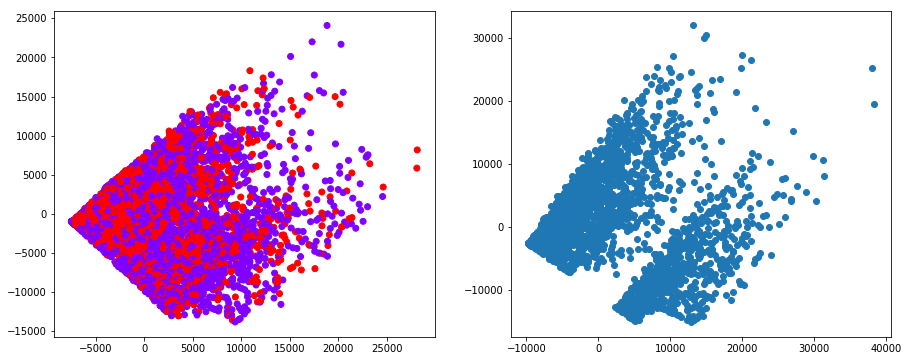

In [9]:
## Principal component analysis (PCA)

## Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. 
## The input data is centered but not scaled for each feature before applying the SVD.
from sklearn.decomposition import PCA

X_pca_train = PCA(n_components=2).fit_transform(X_train)
X_pca_test = PCA(n_components=2).fit_transform(X_test)

f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
ax1.scatter(X_pca_train[:,0],X_pca_train[:,1],c=train['target'],cmap='rainbow')
ax2.scatter(X_pca_test[:,0],X_pca_test[:,1],cmap='rainbow')

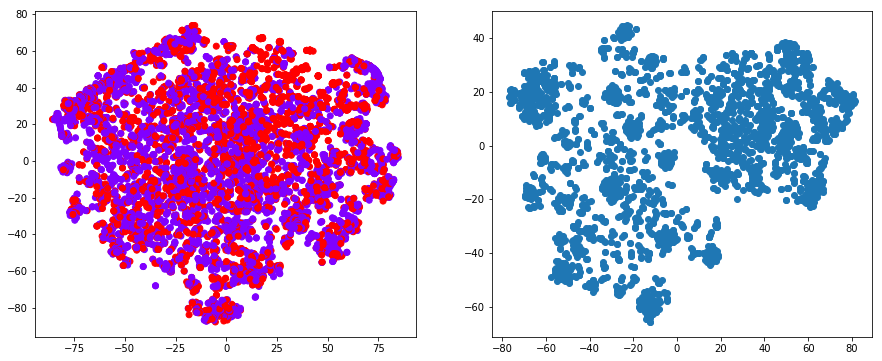

In [10]:
## t-distributed Stochastic Neighbor Embedding (t-SNE)

## t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint 
## probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the 
## low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. 
## with different initializations we can get different results.

from sklearn.manifold import TSNE

X_tsne_train = TSNE(n_components=2).fit_transform(X_train)
X_tsne_test = TSNE(n_components=2).fit_transform(X_test)

f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
ax1.scatter(X_tsne_train[:,0],X_tsne_train[:,1],c=train['target'],cmap='rainbow')
ax2.scatter(X_tsne_test[:,0],X_tsne_test[:,1],cmap='rainbow')

## getting class weights to balance target counts

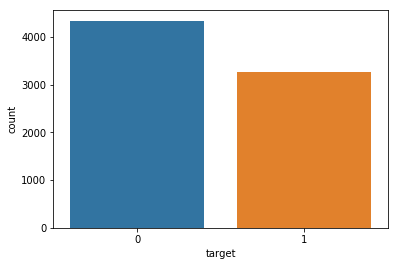

In [11]:
sns.countplot(x=y_train)

In [12]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

print(class_weight) 

<module 'sklearn.utils.class_weight' from '/opt/conda/lib/python3.6/site-packages/sklearn/utils/class_weight.py'>


In [13]:
import keras.backend as K
import tensorflow as tf

def f1(y_true, y_pred):
    """F1 score for Keras model.
    
    Copyright (c) 2018 Guglielmo Camporese.
    
    https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
    
    """
    
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [14]:
## from https://www.kaggle.com/bibek777/lstm-baseline

from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate, BatchNormalization
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import unit_norm, max_norm

LSTM_UNITS = 64

def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = BatchNormalization()(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True, kernel_constraint=unit_norm()))(x)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True, kernel_constraint=unit_norm()))(x)
    x = SpatialDropout1D(0.3)(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])

    hidden = add([hidden, Dense(LSTM_UNITS*4, activation='relu', kernel_constraint=unit_norm())(hidden)])
    #x = SpatialDropout1D(0.3)(x)
    hidden = add([hidden, Dense(LSTM_UNITS*4, activation='relu', kernel_constraint=unit_norm())(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=result)
    adam = Adam(learning_rate=0.00097, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc', f1])

    return model

## tunung the model

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#checkpoint = ModelCheckpoint('model.h5', monitor='val_f1', mode="max", save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=5)
reducelronplateau = ReduceLROnPlateau(monitor='val_loss', patience=5)


BATCH_SIZE = 512
EPOCHS = 15

model = build_model(embedding_matrix)
result = model.fit(
    X_train, y_train,
    validation_split=0.33,
    class_weight=class_weights,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlystopping, reducelronplateau],
    verbose=1)

Train on 5100 samples, validate on 2513 samples
Epoch 1/15
5100/5100 [==============================] - 15s 3ms/sample - loss: 0.6307 - acc: 0.6524 - f1: 0.4399 - val_loss: 0.5552 - val_acc: 0.7417 - val_f1: 0.7440
Epoch 2/15
5100/5100 [==============================] - 6s 1ms/sample - loss: 0.5161 - acc: 0.7571 - f1: 0.6931 - val_loss: 0.5997 - val_acc: 0.6928 - val_f1: 0.7266
Epoch 3/15
5100/5100 [==============================] - 6s 1ms/sample - loss: 0.4782 - acc: 0.7837 - f1: 0.7287 - val_loss: 0.5844 - val_acc: 0.6976 - val_f1: 0.7288
Epoch 4/15
5100/5100 [==============================] - 6s 1ms/sample - loss: 0.4604 - acc: 0.7873 - f1: 0.7238 - val_loss: 0.5325 - val_acc: 0.7433 - val_f1: 0.7540
Epoch 5/15
5100/5100 [==============================] - 6s 1ms/sample - loss: 0.4336 - acc: 0.8059 - f1: 0.7521 - val_loss: 0.4960 - val_acc: 0.7772 - val_f1: 0.7738
Epoch 6/15
5100/5100 [==============================] - 6s 1ms/sample - loss: 0.4188 - acc: 0.8182 - f1: 0.7677 - val_los

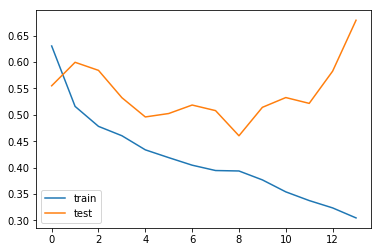

In [16]:
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend()
plt.show()

In [17]:
score = model.evaluate(X_train, y_train, verbose=0)[1]*100
print("%.2f%% (+/- %.2f%%)" % (np.mean(score), np.std(score)))      

81.27% (+/- 0.00%)


In [18]:
NUM_MODELS = 5

checkpoint_predictions = []
weights = []
results = []
cv_scores = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix)
    for global_epoch in range(EPOCHS):
        result = model.fit(
            X_train, y_train,
            class_weight=class_weights,
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=1)
        results.append(result)
        cv_scores.append(model.evaluate(X_train, y_train, verbose=0)[1]*100)
        checkpoint_predictions.append(model.predict(X_test, batch_size=BATCH_SIZE))
        weights.append(2 ** global_epoch)
        
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))        

Train on 7613 samples
7613/7613 [==============================] - 13s 2ms/sample - loss: 0.5798 - acc: 0.7004 - f1: 0.5825
Train on 7613 samples
7613/7613 [==============================] - 8s 1ms/sample - loss: 0.4883 - acc: 0.7751 - f1: 0.7217
Train on 7613 samples
7613/7613 [==============================] - 7s 985us/sample - loss: 0.4575 - acc: 0.7952 - f1: 0.7412
Train on 7613 samples
7613/7613 [==============================] - 7s 976us/sample - loss: 0.4272 - acc: 0.8098 - f1: 0.7620
Train on 7613 samples
7613/7613 [==============================] - 7s 981us/sample - loss: 0.4147 - acc: 0.8221 - f1: 0.7779
Train on 7613 samples
7613/7613 [==============================] - 8s 1ms/sample - loss: 0.4051 - acc: 0.8282 - f1: 0.7854
Train on 7613 samples
7613/7613 [==============================] - 8s 997us/sample - loss: 0.3861 - acc: 0.8324 - f1: 0.7901
Train on 7613 samples
7613/7613 [==============================] - 7s 967us/sample - loss: 0.3731 - acc: 0.8422 - f1: 0.8033
Train

## plot loss and accuracy

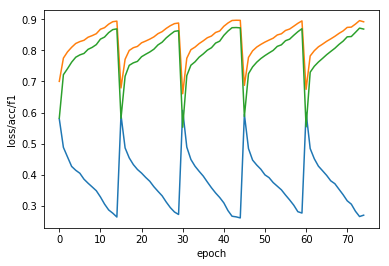

In [19]:
loss_res = []
acc_res = []
f1_res = []

idx = 0
for model in range(NUM_MODELS):
    for epoch in range(EPOCHS):
        loss_res.append(results[idx].history['loss'])
        acc_res.append(results[idx].history['acc'])
        f1_res.append(results[idx].history['f1'])
        idx = idx + 1

# summarize history for loss
plt.plot(loss_res)
plt.plot(acc_res)
plt.plot(f1_res)
plt.ylabel('loss/acc/f1')
plt.xlabel('epoch')
plt.show()

## Submission

In [20]:
predictions = np.average(checkpoint_predictions, weights=weights, axis=0)
y_pred = (predictions > 0.5).astype(int).ravel()

sample_sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pred})
sub.to_csv('submission.csv',index=False)

In [21]:
sub['tweet'] = test['text']
sub.head(25)

,id,target,tweet
0,0,1,Just happened a terrible car crash
1,2,1,"Heard about #earthquake is different cities, s..."
2,3,1,"there is a forest fire at spot pond, geese are..."
3,9,1,Apocalypse lighting. #Spokane #wildfires
4,11,1,Typhoon Soudelor kills 28 in China and Taiwan
5,12,1,We're shaking...It's an earthquake
6,21,0,They'd probably still show more life than Arse...
7,22,0,Hey! How are you?
8,27,0,What a nice hat?
9,29,0,Fuck off!
